## Predicting Customer Churn in Telco Industry: Part II
### Utkarsh Misra
### July, 2021
### Predictive Modeling Using Random Forest
#### This notebook will contain all parts of the predictive modeling process including: feature creation, feature selection, model performance, accuracy testing and hyperparameter tuning. 

In [140]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

### Ingesting Data

In [141]:
data = pd.read_csv('/Users/utkarshmisra/Desktop/Notes/Churn_Dataset.csv')

### Recap From Part I
* Features related to call minutes and call charge are 100% correlated and therefore out of the 6 available, 3 will be selected for any modeling purposes
* Three features: day calls, customer service calls, international plan, and voice mail plan are potentially powerful predictors. 
* Two features were created, one of which showed some promise. This is a combination of the area and state henceforth dubbed "area-state" which was shown to show more variation when it came to differentiating the churners from non-churners
* Note that the feature "phone number" will be excluded from all because it is unique to each customer and also because what it may represent (geographical information) is already represented by other feature(s).

In [142]:
data.dtypes

state                      object
account length              int64
area code                   int64
phone number               object
international plan         object
voice mail plan            object
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night charge        float64
total intl minutes        float64
total intl calls            int64
total intl charge         float64
customer service calls      int64
churn                        bool
dtype: object

#### Type Changes

In [143]:
# Changing into categorical
data['area code'] = data['area code'].astype(object)

#### New Feature Creation

In [144]:
# Based on explroation 
data["area_state"] = data["area code"].astype(str) + '-' + data["state"]


### Feature Selection 
#### Here, I am going forward with two models
1. All the data except with new feature
2. Only selected columns (based on data exploration) which will then be further trimmed based on predictive power

#### Isolating Variables

In [145]:
# Isolating dependent variables
target = data.pop("churn")

In [298]:
# List of columns for reference for easy subsetting
n=0
for col in data.columns:
    print(n,col)
    n += 1

0 state
1 account length
2 area code
3 phone number
4 international plan
5 voice mail plan
6 number vmail messages
7 total day minutes
8 total day calls
9 total day charge
10 total eve minutes
11 total eve calls
12 total eve charge
13 total night minutes
14 total night calls
15 total night charge
16 total intl minutes
17 total intl calls
18 total intl charge
19 customer service calls
20 area_state


In [297]:
# Isolating two sets of features for two models 
mod1 = data.iloc[:,[1,4,5,6,7,8,10,11,13,14,16,17,19,20]]
mod2 = data.iloc[:,[1,4,7,8,10,11,13,14,16,17,19]] # Only strongest features

#### One-Hot Encoding Using Pandas Dummies

In [286]:
# Converting into arrays and checks
mod1 = pd.get_dummies(mod1)
mod2 = pd.get_dummies(mod2)
target = np.array(target)
feat = list(mod1)
feat2 = list(mod2)

### Random Forest Classifier: Setting Up

In [285]:
# Initializing and storing Random Forest Classifier
rfc = RandomForestClassifier()
rfc2 = RandomForestClassifier()

### Model-I: All data

In [287]:
#Separating into train and test
from sklearn.model_selection import train_test_split
x_train1, x_test1, y_train1, y_test1 = train_test_split(mod1, target, test_size=0.30, random_state=9999)

In [288]:
## Training the model ##
rfc.fit(x_train1, y_train1)

RandomForestClassifier()

#### Training Set Error

In [289]:
# Training set error
train_error1 = (1 - rfc.score(x_train1, y_train1))*100
print("Error on training set is {} %".format(round(train_error1,3)))

Error on training set is 0.0 %


#### Test Set Error

In [290]:
# Making predictions on test set #
y_pred1 = rfc.predict(x_test1)

#### Accuracy

In [292]:
accuracy1 = (accuracy_score(y_test1, y_pred1))*100

# Test set error
print("Accuracy on test set is {} %".format(round(accuracy1,3)))

Accuracy on test set is 94.2 %


#### Feature Importance

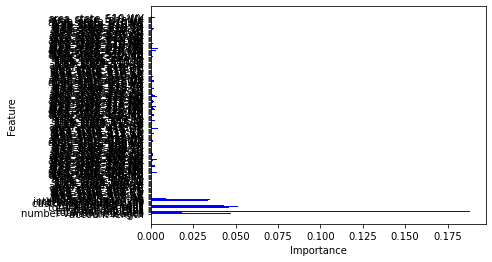

,FeatureName,Importance
2,total day minutes,0.188057
10,customer service calls,0.099570
4,total eve minutes,0.075797
8,total intl minutes,0.059676
6,total night minutes,0.051321
9,total intl calls,0.050267
0,account length,0.047370
3,total day calls,0.045932
5,total eve calls,0.045885
7,total night calls,0.042996


In [293]:

feature_importance1 = rfc.feature_importances_
fig1, ax1 = plt.subplots()
rects = ax1.barh(feat, feature_importance1, 0.5, color='b')

#adding labels
ax1.set_ylabel('Feature')
ax1.set_xlabel('Importance')

plt.show()

feat_table1 = pd.DataFrame(
    {"FeatureName": feat,
    "Importance":feature_importance1}
)

#feat_table_clean = feat_table.style.format({"Importance": ' {:2f}%'})
feat_table1.sort_values("Importance",ascending=False).head(20)

#### AUC and ROC Score: Model-I

#### I will be using the following parameters for testing the performance of the model
- Accuracy or (True Positive+True Negative)/(TP+TN+FP+FN)
- Area Under the Curve (AUC)
- False Negatives: This is because a false negative is more harmful in this case than false positives if the model is used for things such as marketing email blasts or targeted campaigns

In [294]:
#ROC Curve and AUC of MODEL
probs1 = rfc.predict_proba(x_test1)
probs1 = probs1[:, 1]
auc1 = roc_auc_score(y_test1, probs1)
print('AUC: %.3f' % auc1)

AUC: 0.900


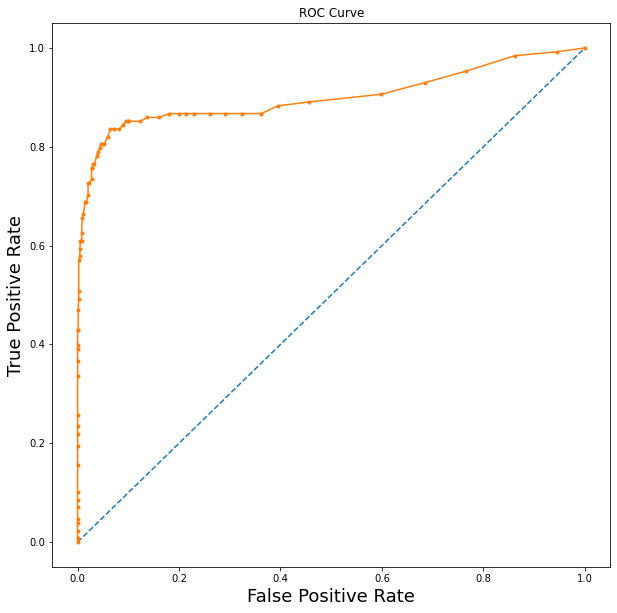

In [295]:
# calculate roc curve
fpr1, tpr1, thresholds1 = roc_curve(y_test1, probs1)
plt.figure(figsize=(10, 10))
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr1, tpr1, marker='.')
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve')
# show the plot
plt.show()

**AUC SCORE OF 90.0**

#### Confusion Matrix To See False Negatives

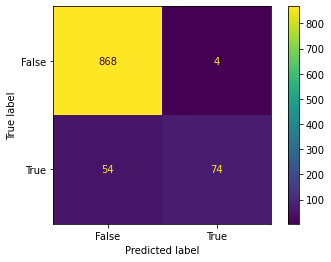

In [296]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test1, y_pred1, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
disp.plot() 

Only **4** false negatives

### Model-II: Only Strongest Features


In [279]:
# Separating into test and train
from sklearn.model_selection import train_test_split
x_train2, x_test2, y_train2, y_test2 = train_test_split(mod2, target, test_size=0.30, random_state=9999)

In [299]:
## Training the model ##
rfc2.fit(x_train2, y_train2)

RandomForestClassifier()

In [281]:
# Training set error
train_error2 = (1 - rfc2.score(x_train2, y_train2))*100
print("Error on training set is {} %".format(round(train_error2,3)))

Error on training set is 0.0 %


In [282]:
# Making predictions on test set #
y_pred2 = rfc2.predict(x_test2)

#### Accuracy

In [283]:
accuracy2 = (accuracy_score(y_test2, y_pred2))*100

# Test set error
print("Accuracy on test set is {} %".format(round(accuracy2,3)))

Accuracy on test set is 94.2 %


#### Feature Importance

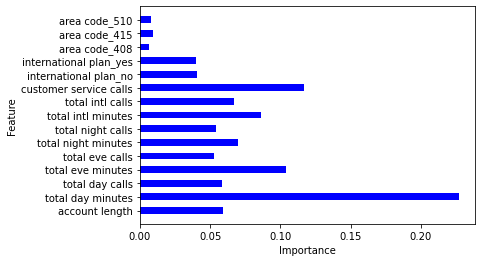

,FeatureName,Importance
1,total day minutes,0.226860
9,customer service calls,0.116612
3,total eve minutes,0.104023
7,total intl minutes,0.085978
5,total night minutes,0.069885
8,total intl calls,0.067025
0,account length,0.059459
2,total day calls,0.058191
6,total night calls,0.054312
4,total eve calls,0.052925


In [276]:
feature_importance2 = rfc2.feature_importances_

fig, ax = plt.subplots()
rects = ax.barh(feat2, feature_importance2, 0.5, color='b')

#adding labels
ax.set_ylabel('Feature')
ax.set_xlabel('Importance')

plt.show()

feat_table2 = pd.DataFrame(
    {"FeatureName": feat2,
    "Importance":feature_importance2}
)

#feat_table_clean = feat_table.style.format({"Importance": ' {:2f}%'})
feat_table2.sort_values("Importance",ascending=False).head(15)

#### AUC and ROC Score: Model-II

In [256]:
#ROC Curve and AUC of MODEL
probs2 = rfc2.predict_proba(x_test2)
probs2 = probs2[:, 1]
auc2 = roc_auc_score(y_test2, probs2)
print('AUC: %.3f' % auc2)

AUC: 0.893


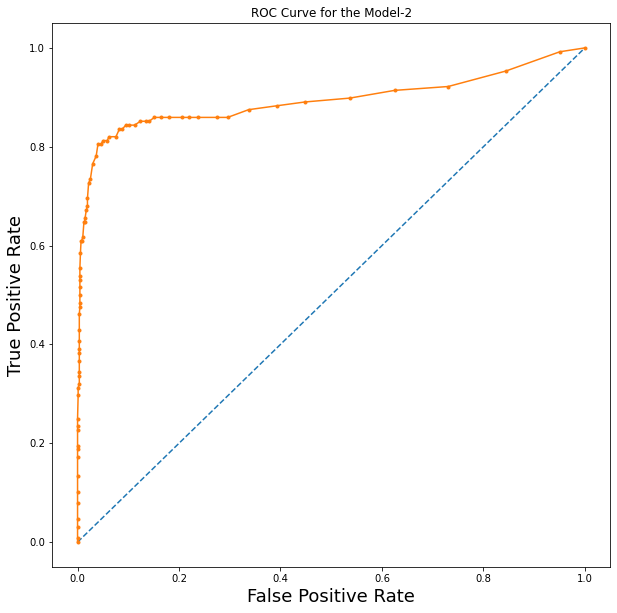

In [257]:
# calculate roc curve
fpr2, tpr2, thresholds2 = roc_curve(y_test2, probs2)
plt.figure(figsize=(10, 10))
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr2, tpr2, marker='.')
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve for the Model-2')
# show the plot
plt.show()

AUC Score of **89.3**

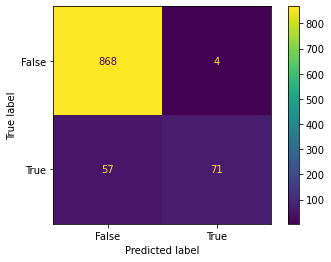

In [258]:
### Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test2, y_pred2, labels=rfc2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc2.classes_)
disp.plot() 

Only **4** false negatives

### Conclusion
1. Go with model-II because even though the accuracy for the first model is slightly higher on the test set (90 > 89.7), it still predicts the same number of false negatives (4). The accuracy is almost the same and any subtle difference can be attributed to random sampling
2. Most importantly, model-2 is much easier to **interpret, collect data for, deploy and requires much less processing power**
3. The voice mail variables and the geographic variables were ultimately not important predictors in their current form. However, it is definitely to engineer these to get more predictive power out of them
4. Top 3 most important predictors:day minutes, customer service calls, and evening minutes. Two out of 3, we accurately isolated as potentially powerful!

### Hyperparameter Tuning

##### Based on research, I am narrowing down the hyperparameter to four:
1. N_estimators: number of trees in forest
2. Max features: Max number of features considered for splitting a node
3. Max depth: Max number of levels in each decision tree
4. Bootstrap: Whether to use bootstrapping method or not

In order to zero down on the best ranges for the parameters, I will be using grid search and start with a wide range of values and then narrow down based on the best params. The process of zeroing down is not shown here, but the final grid used is left 

In [300]:
# Create the parameter grid based on the individual research for best ranges
param_grid = {
    'bootstrap': [True],
    'max_depth': [5,10,15,20,25],
    'max_features': [2, 3],
    'n_estimators': [50,100,200,500,1000]
}


# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc2, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [301]:
 #Fit the grid search to the data
grid_search.fit(x_train2, y_train2)
grid_search.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'bootstrap': True, 'max_depth': 15, 'max_features': 3, 'n_estimators': 200}

### Fitting a Random Forest With the Tuned Parameters

In [302]:
rfc_2f = RandomForestClassifier(max_depth = 15, max_features = 3, n_estimators =200, bootstrap=True)

In [303]:
rfc_2f.fit(x_train2, y_train2)

RandomForestClassifier(max_depth=15, max_features=3, n_estimators=200)

#### Accuracy

In [305]:
# Making predictions on test set #
y_pred2f = rfc_2f.predict(x_test2)

In [306]:
accuracy2f = (accuracy_score(y_test2, y_pred2f))*100

# Test set error
print("Accuracy on test set is {} %".format(round(accuracy2f,3)))

Accuracy on test set is 94.4 %


In [307]:
# Improvement in accuracy ##

print('Improvement of {:0.2f}% from the non-tuned model.'.format( 100 * (accuracy2f - accuracy2) / accuracy2))

Improvement of 0.21% from the non-tuned model.
